<a href="https://colab.research.google.com/github/darrencheninfo/ADS504_G1_Project/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

Note: Cell #5 Remember to change file path. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

### Load Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load in set for Feature Engineering

In [6]:
#import dataset
## df = pd.read_csv(r"E:\Masters Applied Data Science\ADS504\Project\diabetes_df.csv")
# df = pd.read_csv('/content/drive/MyDrive/ADS 504 | Final Project/diabetes_df.csv') # Note replace with your dataset path
df = pd.read_csv('processed_data\diabetes_df.csv')   # #darren's data path

In [7]:
display(df.head())

,_STATE,SEXVAR,GENHLTH,PHYSHLTH,POORHLTH,PRIMINS1,PERSDOC3,MEDCOST1,CHECKUP1,EXERANY2,...,SDHEMPLY,FOODSTMP,SDHFOOD1,SDHBILLS,SDHUTILS,SDHTRNSP,SDHSTRE1,_URBSTAT,_IMPRACE,_AGE80
0,2.0,2.0,3.0,88.0,88.0,3.0,1.0,2.0,1.0,2.0,...,2.0,2.0,5.0,2.0,2.0,2.0,2.0,1.0,1.0,71.0
1,2.0,1.0,2.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0,...,2.0,2.0,5.0,2.0,2.0,2.0,5.0,1.0,1.0,68.0
2,2.0,2.0,3.0,88.0,88.0,7.0,1.0,2.0,1.0,2.0,...,2.0,2.0,5.0,2.0,2.0,2.0,5.0,1.0,1.0,57.0
3,2.0,2.0,2.0,88.0,NaN,3.0,2.0,2.0,1.0,2.0,...,2.0,2.0,5.0,2.0,2.0,2.0,5.0,1.0,1.0,70.0
4,2.0,2.0,5.0,30.0,25.0,3.0,2.0,2.0,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,1.0,74.0


In [8]:
starting_shape= df.shape
print(starting_shape)

(20069, 102)


## Creating the Diabetes Co-Morbidity score

### This will determine how severe their comorbidities are

   Diabetes_Comorbidity_Score  CVDINFR4  CVDCRHD4  CVDSTRK3  ASTHMA3  \
0                         2.0       0.0       0.0       0.0      0.0   
1                         0.0       0.0       0.0       0.0      0.0   
2                         1.0       0.0       0.0       0.0      0.0   
3                         1.0       0.0       0.0       0.0      0.0   
4                         3.0       0.0       0.0       0.0      0.0   
5                         1.0       0.0       0.0       0.0      0.0   
6                         1.0       0.0       0.0       0.0      0.0   
7                         1.0       0.0       0.0       0.0      0.0   
8                         1.0       0.0       0.0       0.0      1.0   
9                         5.0       1.0       1.0       1.0      0.0   

   CHCCOPD3  ADDEPEV3  CHCKDNY2  HAVARTH4  FEETSORE  
0       0.0       1.0       0.0       1.0       0.0  
1       0.0       0.0       0.0       0.0       0.0  
2       0.0       1.0       0.0       0.0    

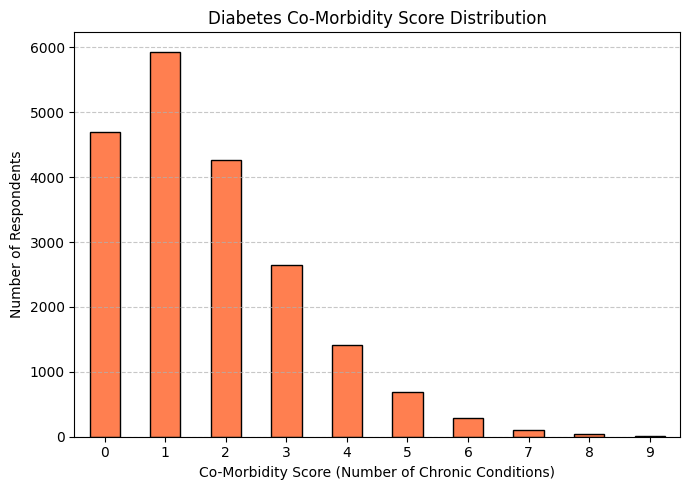

In [9]:
# Define the list of chronic health condition columns
comorbidity_binary_cols = [
    'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3',
    'CHCCOPD3', 'ADDEPEV3',
    'CHCKDNY2', 'HAVARTH4', 'FEETSORE'
]

# Convert all values to numeric, coercing errors to NaN
df[comorbidity_binary_cols] = df[comorbidity_binary_cols].apply(pd.to_numeric, errors='coerce')

# Replace BRFSS "invalid" codes 7, 8, 9 with NaN
for col in comorbidity_binary_cols:
    df.loc[df[col].isin([7, 8, 9]), col] = pd.NA

# Map valid codes — 1 = Yes (1 point), 2 = No (0 point)
df[comorbidity_binary_cols] = df[comorbidity_binary_cols].replace({1: 1, 2: 0})

# Create the Diabetes Comorbidity Score by summing across all chronic condition columns
df["Diabetes_Comorbidity_Score"] = df[comorbidity_binary_cols].sum(axis=1)

# Preview the results
print(df[["Diabetes_Comorbidity_Score"] + comorbidity_binary_cols].head(10))

# Diabetes Co-Morbidity Score Distribution
plt.figure(figsize=(7, 5))
df['Diabetes_Comorbidity_Score'].dropna().astype(int).value_counts().sort_index().plot(
    kind='bar',
    color='coral',
    edgecolor='black'
)
plt.title('Diabetes Co-Morbidity Score Distribution')
plt.xlabel('Co-Morbidity Score (Number of Chronic Conditions)')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [10]:
#drop comorbidity cols:
df = df.drop(columns=comorbidity_binary_cols)
comorbid_shape = df.shape
print(f"Original dataframe shape:", starting_shape)
print(f"New shape after comorbidity indicator:", comorbid_shape)

Original dataframe shape: (20069, 102)
New shape after comorbidity indicator: (20069, 94)


This shows the co-morbidity score that a patient could have. A score of 0 means that there are no relavent chronic conditions report and a score of 5 means that there could be multiple co-existing conditions.

## Creation of a Diabetic Care Score

### This will determine how patients are taking care of their diabetes

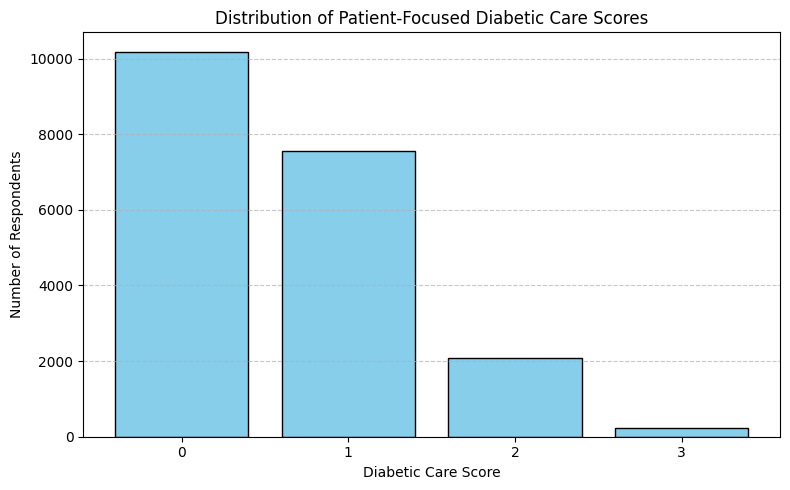

In [11]:
# Columns that indicate proactive diabetic care
patient_focused_cols = ['INSULIN1', 'EYEEXAM1', 'DIABEDU1']

#  Convert to numeric
df[patient_focused_cols] = df[patient_focused_cols].apply(pd.to_numeric, errors='coerce')

# Set invalid values to NaN

# INSULIN1 and DIABEDU1: Only 1 (Yes) and 2 (No) are valid
df['INSULIN1'] = df['INSULIN1'].where(df['INSULIN1'].isin([1, 2]), pd.NA)
df['DIABEDU1'] = df['DIABEDU1'].where(df['DIABEDU1'].isin([1, 2]), pd.NA)

# EYEEXAM1: Only values 1–5 are valid; 1 = within past year is a positive indicator
df['EYEEXAM1'] = df['EYEEXAM1'].where(df['EYEEXAM1'].isin([1, 2, 3, 4, 5]), pd.NA)

#  Map values
df['INSULIN1'] = df['INSULIN1'].replace({1: 1, 2: 0})
df['DIABEDU1'] = df['DIABEDU1'].replace({1: 1, 2: 0})
df['EYEEXAM1'] = df['EYEEXAM1'].apply(lambda x: 1 if x == 1 else 0 if x in [2, 3, 4, 5] else pd.NA)

# Compute the Diabetic Care Score
df["Diabetic_Care_Score"] = df[patient_focused_cols].sum(axis=1)

# Visualization – Histogram of Diabetic Care Scores
plt.figure(figsize=(8, 5))
plt.hist(df["Diabetic_Care_Score"].dropna(), bins=[0,1,2,3,4], align='left', color='skyblue', edgecolor='black', rwidth=0.8)
plt.title("Distribution of Patient-Focused Diabetic Care Scores")
plt.xlabel("Diabetic Care Score")
plt.ylabel("Number of Respondents")
plt.xticks([0, 1, 2, 3])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The higher diabetic care score (3) means that a patient is doing more to help with their diabetes care. It means they are taking their medicine, going to the eye doctor and enrolling in their diabetes self care class. It can be seen that many patients are not doing enough to take care of their diabetic problems

In [12]:
#drop patient cols:
df = df.drop(columns=patient_focused_cols)
patient_shape = df.shape
print(f"Last updated dataframe shape:", comorbid_shape)
print(f"New shape after patient focused indicator:", patient_shape)

Last updated dataframe shape: (20069, 94)
New shape after patient focused indicator: (20069, 92)


## Disability Factor

### This will note if any patients have any disabilities

   Disability_Score  DEAF  BLIND  DECIDE  DIFFWALK  DIFFDRES  DIFFALON
0               0.0   0.0    0.0     0.0       0.0       0.0       0.0
1               0.0   0.0    0.0     0.0       0.0       0.0       0.0
2               0.0   0.0    0.0     0.0       0.0       0.0       0.0
3               1.0   0.0    0.0     0.0       1.0       0.0       0.0
4               3.0   0.0    NaN     1.0       1.0       NaN       1.0
5               1.0   0.0    0.0     0.0       0.0       0.0       1.0
6               1.0   0.0    0.0     0.0       1.0       0.0       0.0
7               0.0   0.0    0.0     0.0       0.0       0.0       0.0
8               0.0   0.0    0.0     0.0       0.0       0.0       0.0
9               5.0   1.0    0.0     1.0       1.0       1.0       1.0


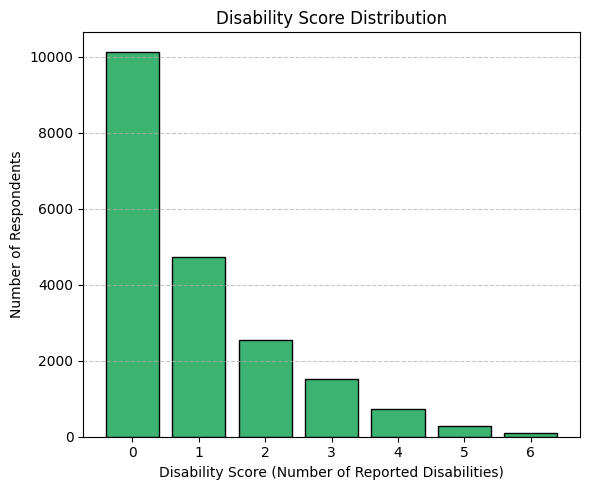

In [13]:
# Define the disability-related columns
disability_cols = ['DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON']

# Ensure all are numeric and set invalid codes (7, 8, 9) to NA
df[disability_cols] = df[disability_cols].apply(pd.to_numeric, errors='coerce')
for col in disability_cols:
    df.loc[df[col].isin([7, 8, 9]), col] = pd.NA

# Map valid codes — 1 = Yes (1 point), 2 = No (0 point)
df[disability_cols] = df[disability_cols].replace({1: 1, 2: 0})

# Create a numerical disability score by summing across all disability columns
df['Disability_Score'] = df[disability_cols].sum(axis=1)

# View sample rows
print(df[['Disability_Score'] + disability_cols].head(10))

# Disability Score Distribution
plt.figure(figsize=(6, 5))
plt.hist(df["Disability_Score"].dropna(), bins=range(len(disability_cols) + 2), align='left', color='mediumseagreen', edgecolor='black', rwidth=0.8)
plt.title('Disability Score Distribution')
plt.xlabel('Disability Score (Number of Reported Disabilities)')
plt.ylabel('Number of Respondents')
plt.xticks(range(len(disability_cols) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
#drop disability cols:
df = df.drop(columns=disability_cols)
disability_shape = df.shape
print(f"Last updated dataframe shape:", patient_shape)
print(f"New shape after new indicator:", disability_shape)

Last updated dataframe shape: (20069, 92)
New shape after new indicator: (20069, 87)


## Proactive Care Score

Proactive Care Score and Access to Care Score previews:
  Proactive_Care_Score Access_to_Care_Score
0                    2                    3
1                    3                    3
2                    3                    3
3                    2                    2
4                    1                    2
5                    3                    3
6                    0                    4
7                    3                    3
8                    2                    2
9                    2                    3


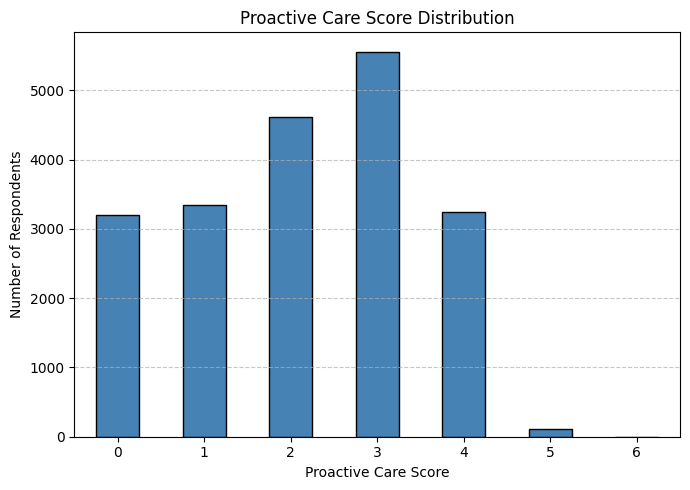

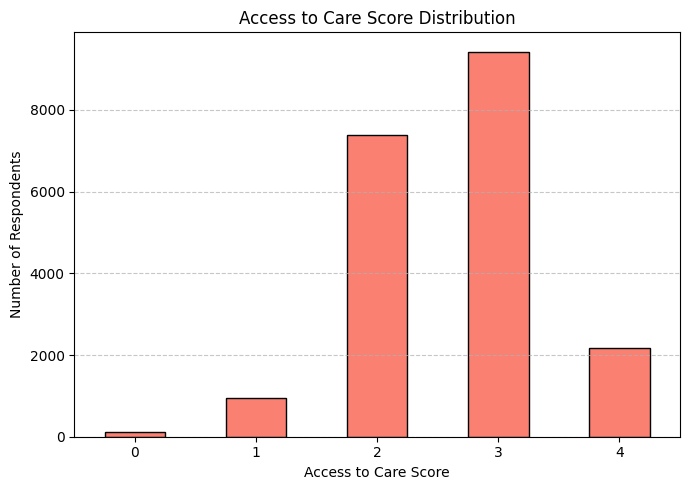

In [15]:
# Define relevant columns for Proactive Care and Access to Care
proactive_care_cols_list = [
    'COVIDVA1', 'COVACGE1', 'COVIDNU2',  # COVID Vaccination
    'FLUSHOT7', 'PNEUVAC4',  # Immunization
    'HPVADVC4', 'HPVADSHT',  # HPV Vaccination
    'TETANUS1',  # Tetanus/Diptheria
    'SHINGLE2' , #shingles
]

access_to_care_cols_list = [
    'PRIMINS1', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1'  # Healthcare Access
]

# Ensure numeric and set invalid codes (7, 8, 9) to NA for all relevant columns in both lists
all_care_cols = proactive_care_cols_list + access_to_care_cols_list

df[all_care_cols] = df[all_care_cols].apply(pd.to_numeric, errors='coerce')
for col in all_care_cols:
    df.loc[df[col].isin([7, 8, 9]), col] = pd.NA

# Scoring rules: 1 point for each proactive "yes" response or positive access indicator

# Proactive Care Scoring: Values of 1 typically indicate "yes" or "positive care behavior"
# Ensure only proactive care columns are used for this score
proactive_binary = df[proactive_care_cols_list].apply(lambda col: col.apply(lambda x: 1 if x == 1 else 0 if pd.notna(x) else pd.NA))
df['Proactive_Care_Score'] = proactive_binary.sum(axis=1)

# Access to Care Scoring:
# PRIMINS1, PERSDOC3, CHECKUP1: 1 = Yes (1 point), 2 = No (0 points)
# MEDCOST1: 1 = Yes (0 points), 2 = No (1 point) -  reverse scoring for this one
# Ensure only access to care columns are used for this score
access_binary = df[access_to_care_cols_list].copy() # Create a copy to avoid SettingWithCopyWarning

# Correcting the mapping for access_binary - ensuring only valid codes are mapped
access_binary['PRIMINS1'] = access_binary['PRIMINS1'].apply(lambda x: 1 if x == 1 else 0 if x == 2 else pd.NA)
access_binary['PERSDOC3'] = access_binary['PERSDOC3'].apply(lambda x: 1 if x == 1 else 0 if x == 2 else pd.NA)
access_binary['CHECKUP1'] = access_binary['CHECKUP1'].apply(lambda x: 1 if x == 1 else 0 if x == 2 else pd.NA)
access_binary['MEDCOST1'] = access_binary['MEDCOST1'].apply(lambda x: 0 if x == 1 else 1 if x == 2 else pd.NA) # Reverse scoring

df['Access_to_Care_Score'] = access_binary.sum(axis=1)


# Print preview of the new scores
print("Proactive Care Score and Access to Care Score previews:")
print(df[['Proactive_Care_Score', 'Access_to_Care_Score']].head(10))


# Plot: Proactive Care Score Distribution
plt.figure(figsize=(7, 5))
df['Proactive_Care_Score'].dropna().astype(int).value_counts().sort_index().plot(
    kind='bar',
    color='steelblue',
    edgecolor='black'
)
plt.title('Proactive Care Score Distribution')
plt.xlabel('Proactive Care Score')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot: Access to Care Score Distribution
plt.figure(figsize=(7, 5))
df['Access_to_Care_Score'].dropna().astype(int).value_counts().sort_index().plot(
    kind='bar',
    color='salmon',
    edgecolor='black'
)
plt.title('Access to Care Score Distribution')
plt.xlabel('Access to Care Score')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
#drop proactive cols:
df = df.drop(columns=proactive_care_cols_list)
proactive_shape = df.shape
print(f"Last updated dataframe shape:", disability_shape)
print(f"New shape after new indicator:", proactive_shape)

Last updated dataframe shape: (20069, 87)
New shape after new indicator: (20069, 80)


In [17]:
#drop acces to care cols:
df = df.drop(columns=access_to_care_cols_list)
access_shape = df.shape
print(f"Last updated dataframe shape:", proactive_shape)
print(f"New shape after patient focused indicator:",access_shape )

Last updated dataframe shape: (20069, 80)
New shape after patient focused indicator: (20069, 76)


## Alcohol Abuse Indicator

### This will tell us if patients are abusing alcohol while under treatment for diabetes

  Alcohol_Abuse_Indicator  AVEDRNK3  DRNKDRI2
0                    <NA>       NaN       NaN
1                       0       1.0       NaN
2                    <NA>       NaN       NaN
3                    <NA>       NaN       NaN
4                    <NA>       NaN       NaN
5                    <NA>       NaN       NaN
6                       0       1.0       NaN
7                    <NA>       NaN       NaN
8                    <NA>       NaN       NaN
9                    <NA>       NaN       NaN


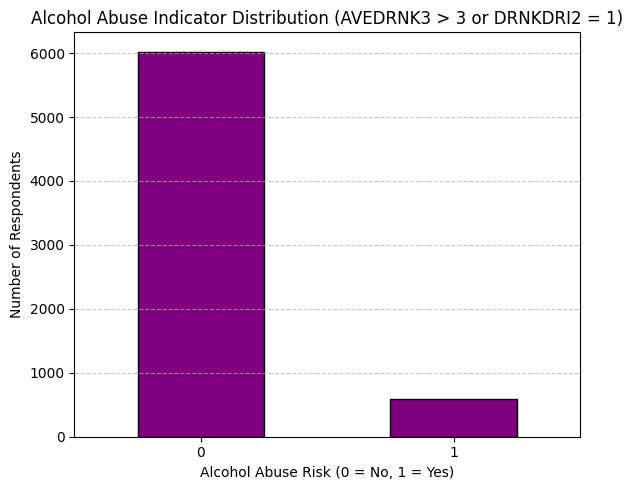

In [18]:
# Define relevant columns
alcohol_risk_cols = ['AVEDRNK3', 'DRNKDRI2']

# Convert to numeric and clean up invalid codes
df[alcohol_risk_cols] = df[alcohol_risk_cols].apply(pd.to_numeric, errors='coerce')
for col in alcohol_risk_cols:
    df.loc[df[col].isin([7, 8, 9, 77, 88, 99]), col] = pd.NA

# Define the alcohol risk function using only AVEDRNK3 and DRNKDRI2
def alcohol_risk(row):
    # Alcohol abuse indicator is 1 if average drinks > 3 OR if reported drinking and driving
    if (pd.notna(row['AVEDRNK3']) and row['AVEDRNK3'] > 3) or (row['DRNKDRI2'] == 1):
        return 1
    # If AVEDRNK3 is not > 3 and DRNKDRI2 is not 1, and neither are NA, return 0
    elif pd.notna(row['AVEDRNK3']) or pd.notna(row['DRNKDRI2']):
         return 0
    # If both are NA, return NA
    else:
        return pd.NA


# Apply to dataset
df['Alcohol_Abuse_Indicator'] = df[alcohol_risk_cols].apply(alcohol_risk, axis=1)

#  Preview result
print(df[['Alcohol_Abuse_Indicator'] + alcohol_risk_cols].head(10))

# Plot: Alcohol Abuse Indicator Distribution
plt.figure(figsize=(6, 5))
# Drop NA values before plotting to avoid errors with value_counts
alcohol_abuse_counts = df['Alcohol_Abuse_Indicator'].dropna().value_counts().sort_index()
alcohol_abuse_counts.plot(
    kind='bar',
    color='purple',
    edgecolor='black'
)
plt.title('Alcohol Abuse Indicator Distribution (AVEDRNK3 > 3 or DRNKDRI2 = 1)')
plt.xlabel('Alcohol Abuse Risk (0 = No, 1 = Yes)')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
#drop alcohol cols:
df = df.drop(columns=alcohol_risk_cols)
alcohol_shape = df.shape
print(f"Last updated dataframe shape:", access_shape)
print(f"New shape after new indicator:",alcohol_shape )

Last updated dataframe shape: (20069, 76)
New shape after new indicator: (20069, 75)


## Exercise Indicator

In [20]:
df['EXERANY2'] = pd.to_numeric(df['EXERANY2'], errors='coerce')  # Converts to numeric, sets non-numeric to NaN
df['EXERANY2'] = df['EXERANY2'].replace({7: pd.NA, 9: pd.NA})    # Replace 7 and 9 with null (NA)
#drop unneeded exercise colums
exercise_cols = ['EXRACT12', 'EXERHMM1', 'EXEROFT1', 'EXRACT22', 'EXEROFT2', 'EXERHMM2', 'STRENGTH' ]

df = df.drop(columns=exercise_cols)
exercise_shape = df.shape
print(f"Last updated dataframe shape:", alcohol_shape)
print(f"New shape after new indicator:",exercise_shape )

Last updated dataframe shape: (20069, 75)
New shape after new indicator: (20069, 68)


## Tobacco Indicator

   Tobacco_Score  SMOKE100  SMOKDAY2  USENOW3  ECIGNOW2
0            8.0       1.0       3.0      3.0       1.0
1            4.0       0.0       NaN      3.0       1.0
2            6.0       1.0       1.0      3.0       1.0
3            4.0       0.0       NaN      3.0       1.0
4            4.0       NaN       NaN      3.0       1.0
5            4.0       0.0       NaN      3.0       1.0
6            8.0       1.0       3.0      3.0       1.0
7            8.0       1.0       3.0      3.0       1.0
8            4.0       0.0       NaN      3.0       1.0
9           11.0       1.0       3.0      3.0       4.0


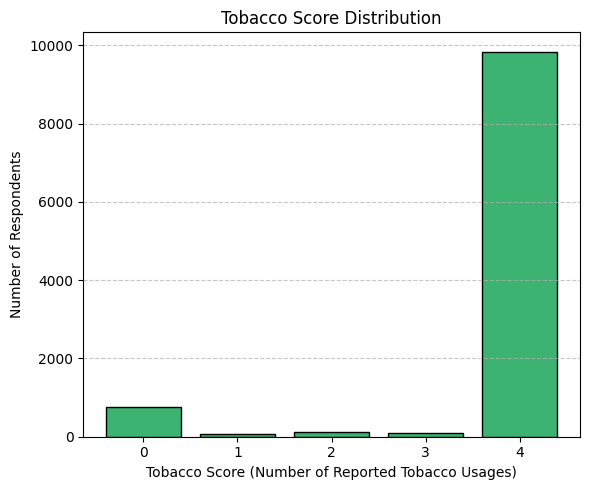

In [21]:
# Define the tabocco-related columns
tobacco_cols = ['SMOKE100', 'SMOKDAY2', 'USENOW3', 'ECIGNOW2']

# Ensure all are numeric and set invalid codes (7, 8, 9) to NA
df[tobacco_cols] = df[tobacco_cols].apply(pd.to_numeric, errors='coerce')
for col in tobacco_cols:
    df.loc[df[col].isin([7, 8, 9]), col] = pd.NA

# Map valid codes — 1 = Yes (1 point), 2 = No (0 point)
df[tobacco_cols] = df[tobacco_cols].replace({1: 1, 2: 0})

# Create a numerical tobacco score by summing across all disability columns
df['Tobacco_Score'] = df[tobacco_cols].sum(axis=1)

# View sample rows
print(df[['Tobacco_Score'] + tobacco_cols].head(10))

# tobacco Score Distribution
plt.figure(figsize=(6, 5))
plt.hist(df["Tobacco_Score"].dropna(), bins=range(len(tobacco_cols) + 2), align='left', color='mediumseagreen', edgecolor='black', rwidth=0.8)
plt.title('Tobacco Score Distribution')
plt.xlabel('Tobacco Score (Number of Reported Tobacco Usages)')
plt.ylabel('Number of Respondents')
plt.xticks(range(len(tobacco_cols) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
#drop tobacco cols:
df = df.drop(columns=tobacco_cols)
tobacco_shape = df.shape
print(f"Last updated dataframe shape:", exercise_shape)
print(f"New shape after new indicator:",tobacco_shape )

Last updated dataframe shape: (20069, 68)
New shape after new indicator: (20069, 65)


## Social Determininates Indicator

In [23]:
sdo_cols = [
    'LSATISFY',  # 1–4, lower=better; high (3–4) is risk
    'EMTSUPRT',  # 1–5, lower=better; high (4–5) is risk
    'SDLONELY',  # 1–5, lower=worse; low (1–2) is risk
    'SDHEMPLY',  # 1–2, lower=worse; 1 is risk
    'FOODSTMP',  # 1–2, lower=worse; 1 is risk
    'SDHFOOD1',  # 1–5, lower=worse; low (1–2) is risk
    'SDHBILLS',  # 1–2, lower=worse; 1 is risk
    'SDHUTILS',  # 1–2, lower=worse; 1 is risk
    'SDHTRNSP',  # 1–2, lower=worse; 1 is risk
    'SDHSTRE1'   # 1–5, lower=worse; low (1–2) is risk
]
df[sdo_cols] = df[sdo_cols].apply(pd.to_numeric, errors='coerce')
df[sdo_cols] = df[sdo_cols].replace({7: pd.NA, 8: pd.NA, 9: pd.NA})

#define thresholds where there is a risk based on columns
risk_defs = {
    'LSATISFY': lambda x: x >= 3,
    'EMTSUPRT': lambda x: x >= 4,
    'SDLONELY': lambda x: x <= 2,
    'SDHEMPLY': lambda x: x == 1,
    'FOODSTMP': lambda x: x == 1,
    'SDHFOOD1': lambda x: x <= 2,
    'SDHBILLS': lambda x: x == 1,
    'SDHUTILS': lambda x: x == 1,
    'SDHTRNSP': lambda x: x == 1,
    'SDHSTRE1': lambda x: x <= 2,
}
for col, rule in risk_defs.items():
    df[f'{col}_risk'] = df[col].map(rule).astype('Int64')
risk_flags = [f'{c}_risk' for c in sdo_cols]
df['social_score'] = df[risk_flags].sum(axis=1)
print(df[['social_score'] + risk_flags].head())

   social_score  LSATISFY_risk  EMTSUPRT_risk  SDLONELY_risk  SDHEMPLY_risk  \
0             1              0              0              0              0   
1             0              0              0              0              0   
2             0              0              0              0              0   
3             0              0              0              0              0   
4             2              1              0              0              0   

   FOODSTMP_risk  SDHFOOD1_risk  SDHBILLS_risk  SDHUTILS_risk  SDHTRNSP_risk  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              1              0              0              0   

   SDHSTRE1_risk  
0              1  
1     

In [24]:
#drop risk cols:
df = df.drop(columns=sdo_cols)
df= df.drop(columns=risk_flags)
sdo_shape = df.shape
print(f"Last updated dataframe shape:", tobacco_shape)
print(f"New shape after new indicator:",sdo_shape )

Last updated dataframe shape: (20069, 65)
New shape after new indicator: (20069, 56)


## Marijuana Use

   Marijuana_Score  MARJSMOK  MARJEAT  MARJVAPE  MARJDAB  MARJOTHR
0              0.0       NaN      NaN       NaN      NaN       NaN
1              0.0       NaN      NaN       NaN      NaN       NaN
2              0.0       NaN      NaN       NaN      NaN       NaN
3              0.0       NaN      NaN       NaN      NaN       NaN
4              0.0       NaN      NaN       NaN      NaN       NaN
5              0.0       NaN      NaN       NaN      NaN       NaN
6              0.0       NaN      NaN       NaN      NaN       NaN
7              0.0       NaN      NaN       NaN      NaN       NaN
8              0.0       NaN      NaN       NaN      NaN       NaN
9              0.0       NaN      NaN       NaN      NaN       NaN


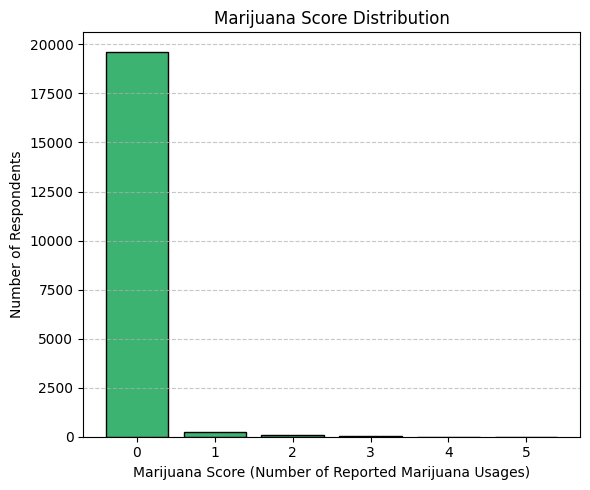

In [25]:
import matplotlib.pyplot as plt

mar_cols = ['MARJSMOK', 'MARJEAT', 'MARJVAPE', 'MARJDAB', 'MARJOTHR']
df[mar_cols] = df[mar_cols].apply(pd.to_numeric, errors='coerce')
for col in mar_cols:
    df.loc[df[col].isin([7, 8, 9]), col] = pd.NA

# Map valid codes — 1 = Yes (1 point), 2 = No (0 point)
df[mar_cols] = df[mar_cols].replace({1: 1, 2: 0})

# Create a numerical marijuana score by summing across all marijuana columns
df['Marijuana_Score'] = df[mar_cols].sum(axis=1)

# View sample rows
print(df[['Marijuana_Score'] + mar_cols].head(10))

# Visualize
plt.figure(figsize=(6, 5))
plt.hist(
    df["Marijuana_Score"].dropna(),
    bins=range(len(mar_cols) + 2),
    align='left',
    color='mediumseagreen',
    edgecolor='black',
    rwidth=0.8
)
plt.title('Marijuana Score Distribution')
plt.xlabel('Marijuana Score (Number of Reported Marijuana Usages)')
plt.ylabel('Number of Respondents')
plt.xticks(range(len(mar_cols) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [26]:
#drop Marijuana cols:
df = df.drop(columns=mar_cols)
mar_shape = df.shape
print(f"Last updated dataframe shape:", sdo_shape)
print(f"New shape after new indicator:",mar_shape )

Last updated dataframe shape: (20069, 56)
New shape after new indicator: (20069, 52)


## Cognitive Decline

   Cognitive_Score  CIMEMLO1  CDWORRY  CDDISCU1  CDHOUS1  CDSOCIA1
0              0.0       NaN      NaN       NaN      NaN       NaN
1              0.0       NaN      NaN       NaN      NaN       NaN
2              0.0       NaN      NaN       NaN      NaN       NaN
3              0.0       NaN      NaN       NaN      NaN       NaN
4              0.0       NaN      NaN       NaN      NaN       NaN
5              0.0       NaN      NaN       NaN      NaN       NaN
6              0.0       NaN      NaN       NaN      NaN       NaN
7              0.0       NaN      NaN       NaN      NaN       NaN
8              0.0       NaN      NaN       NaN      NaN       NaN
9              0.0       NaN      NaN       NaN      NaN       NaN


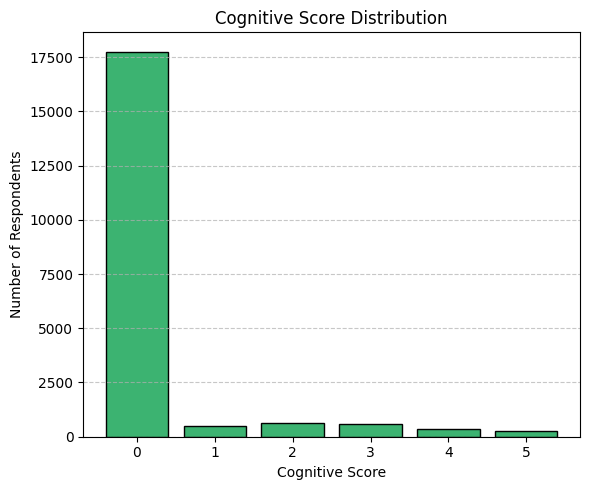

In [27]:
import matplotlib.pyplot as plt

cog_cols = ['CIMEMLO1', 'CDWORRY', 'CDDISCU1', 'CDHOUS1', 'CDSOCIA1']
df[cog_cols] = df[cog_cols].apply(pd.to_numeric, errors='coerce')
for col in cog_cols:
    df.loc[df[col].isin([7, 8, 9]), col] = pd.NA

# Map valid codes — 1 = Yes (1 point), 2 = No (0 point)
df[cog_cols] = df[cog_cols].replace({1: 1, 2: 0})

# Create a numerical marijuana score by summing across all marijuana columns
df['Cognitive_Score'] = df[cog_cols].sum(axis=1)

# View sample rows
print(df[['Cognitive_Score'] + cog_cols].head(10))

# Visualize
plt.figure(figsize=(6, 5))
plt.hist(
    df["Cognitive_Score"].dropna(),
    bins=range(len(cog_cols) + 2),
    align='left',
    color='mediumseagreen',
    edgecolor='black',
    rwidth=0.8
)
plt.title('Cognitive Score Distribution')
plt.xlabel('Cognitive Score')
plt.ylabel('Number of Respondents')
plt.xticks(range(len(cog_cols) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [28]:
#drop Cognitive cols:
df = df.drop(columns=cog_cols)
cog_shape = df.shape
print(f"Last updated dataframe shape:", mar_shape)
print(f"New shape after new indicator:",cog_shape )

Last updated dataframe shape: (20069, 52)
New shape after new indicator: (20069, 48)


## Convert all height and weight values to imperial and implement BMI system

  Height_in_Inches Weight_in_Lbs  BMI_Value BMI_Category
0             64.0         230.0  39.475098        Obese
1             64.0         135.0  23.170166       Normal
2             62.0         140.0  25.603538   Overweight
3             60.0         220.0  42.961111        Obese
4             60.0          <NA>       <NA>         <NA>
5             64.0         155.0  26.602783   Overweight
6             63.0         220.0  38.966994        Obese
7             <NA>          <NA>       <NA>         <NA>
8             73.0         210.0  27.703134   Overweight
9             70.0         150.0  21.520408       Normal


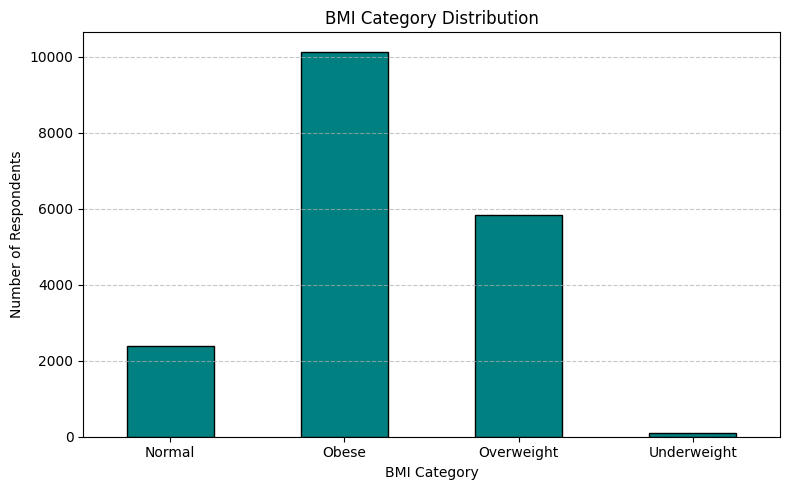

In [29]:
# Clean height
def convert_height_to_inches(height_code):
    if 200 <= height_code <= 711:
        feet = height_code // 100
        inches = height_code % 100
        return feet * 12 + inches
    elif 9061 <= height_code <= 9998:
        return (height_code - 9000) / 2.54  # convert cm to inches
    else:
        return pd.NA

# Clean weight
def convert_weight_to_lbs(weight_code):
    if 50 <= weight_code <= 776:
        return weight_code
    elif 9023 <= weight_code <= 9352:
        return (weight_code - 9000) * 2.20462  # convert kg to lbs
    else:
        return pd.NA

df["Height_in_Inches"] = df["HEIGHT3"].apply(convert_height_to_inches)
df["Weight_in_Lbs"] = df["WEIGHT2"].apply(convert_weight_to_lbs)

# Calculate BMI
df["BMI_Value"] = df["Weight_in_Lbs"] / (df["Height_in_Inches"] ** 2) * 703

# BMI category
def categorize_bmi(bmi):
    if pd.isna(bmi):
        return pd.NA
    elif bmi < 18.5:
        return "Underweight"
    elif bmi < 25:
        return "Normal"
    elif bmi < 30:
        return "Overweight"
    else:
        return "Obese"

df["BMI_Category"] = df["BMI_Value"].apply(categorize_bmi)

# Show preview
print(df[[ "Height_in_Inches", "Weight_in_Lbs", "BMI_Value", "BMI_Category"]].head(10))

# Visualization
bmi_counts = df["BMI_Category"].value_counts(dropna=True).sort_index()
plt.figure(figsize=(8, 5))
bmi_counts.plot(kind="bar", color="teal", edgecolor="black")
plt.title("BMI Category Distribution")
plt.xlabel("BMI Category")
plt.ylabel("Number of Respondents")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## Regional State tracker to see the differences per state

Region
East North Central    4823
West North Central    3844
New England           2212
South Atlantic        2156
West South Central    1681
Pacific               1616
Mountain              1598
Middle Atlantic        894
East South Central     755
NaN                    490
Name: count, dtype: int64


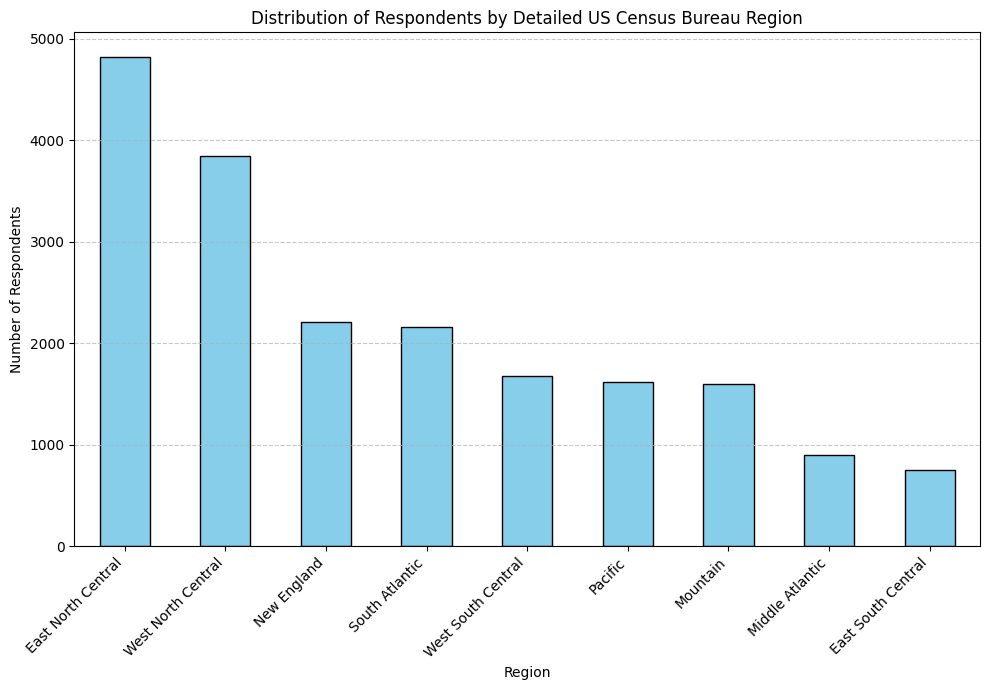

In [30]:
# Dictionary mapping state codes to the detailed US Census Bureau regions
state_to_detailed_region = {
    # New England Division
    9: 'New England', 33: 'New England', 34: 'New England', 44: 'New England', 50: 'New England', 23: 'New England',

    # Middle Atlantic Division
    36: 'Middle Atlantic', 42: 'Middle Atlantic', 34: 'Middle Atlantic',

    # East North Central Division
    17: 'East North Central', 18: 'East North Central', 26: 'East North Central', 39: 'East North Central', 55: 'East North Central',

    # West North Central Division
    19: 'West North Central', 20: 'West North Central', 27: 'West North Central', 29: 'West North Central', 31: 'West North Central', 38: 'West North Central', 46: 'West North Central',

    # South Atlantic Division
    10: 'South Atlantic', 11: 'South Atlantic', 12: 'South Atlantic', 13: 'South Atlantic', 24: 'South Atlantic', 37: 'South Atlantic', 45: 'South Atlantic', 51: 'South Atlantic', 54: 'South Atlantic',

    # East South Central Division
    1: 'East South Central', 21: 'East South Central', 28: 'East South Central', 47: 'East South Central',

    # West South Central Division
    5: 'West South Central', 22: 'West South Central', 48: 'West South Central', 72: 'West South Central',

    # Mountain Division
    4: 'Mountain', 8: 'Mountain', 16: 'Mountain', 30: 'Mountain', 32: 'Mountain', 35: 'Mountain', 49: 'Mountain', 56: 'Mountain',

    # Pacific Division
    2: 'Pacific', 6: 'Pacific', 41: 'Pacific', 53: 'Pacific', 15: 'Pacific',


}

# Create the 'Region' column based on the '_STATE' column using the detailed mapping
# Use .map() to assign regions based on the state codes

df['Region'] = df['_STATE'].map(state_to_detailed_region)

# Display the value counts for the new 'Region' column to check the distribution
print(df['Region'].value_counts(dropna=False))

# Visualize the distribution of the new 'Region' column
plt.figure(figsize=(10, 7))
df['Region'].value_counts(dropna=True).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Respondents by Detailed US Census Bureau Region')
plt.xlabel('Region')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Comparing all features against the regions


In [31]:
# Define the list of key health indicators to compare across regions
key_health_indicators = [
    'Diabetes_Comorbidity_Score',
    'Diabetic_Care_Score',
    'Disability_Indicator',
    'Proactive_Care_Score',
    'Alcohol_Abuse_Indicator',
    'BMI_Category',
    'GENHLTH' # General Health
]

print("Selected key health indicators for regional analysis:")
print(key_health_indicators)

Selected key health indicators for regional analysis:
['Diabetes_Comorbidity_Score', 'Diabetic_Care_Score', 'Disability_Indicator', 'Proactive_Care_Score', 'Alcohol_Abuse_Indicator', 'BMI_Category', 'GENHLTH']


## Visualize distributions by region




In [32]:
# Removed redundant definitions and loop from this cell

  Height_in_Inches Weight_in_Lbs  BMI_Value BMI_Category
0             64.0         230.0  39.475098        Obese
1             64.0         135.0  23.170166       Normal
2             62.0         140.0  25.603538   Overweight
3             60.0         220.0  42.961111        Obese
4             60.0          <NA>       <NA>         <NA>
5             64.0         155.0  26.602783   Overweight
6             63.0         220.0  38.966994        Obese
7             <NA>          <NA>       <NA>         <NA>
8             73.0         210.0  27.703134   Overweight
9             70.0         150.0  21.520408       Normal


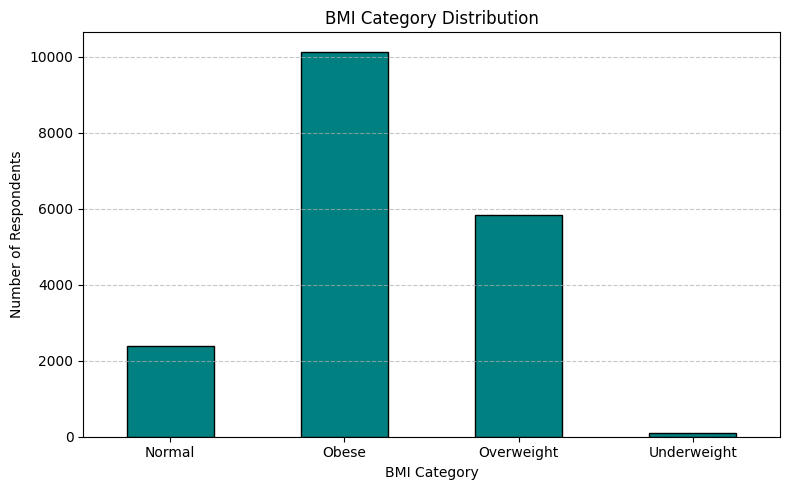

In [33]:
# Clean height
def convert_height_to_inches(height_code):
    if 200 <= height_code <= 711:
        feet = height_code // 100
        inches = height_code % 100
        return feet * 12 + inches
    elif 9061 <= height_code <= 9998:
        return (height_code - 9000) / 2.54  # convert cm to inches
    else:
        return pd.NA

# Clean weight
def convert_weight_to_lbs(weight_code):
    if 50 <= weight_code <= 776:
        return weight_code
    elif 9023 <= weight_code <= 9352:
        return (weight_code - 9000) * 2.20462  # convert kg to lbs
    else:
        return pd.NA

df["Height_in_Inches"] = df["HEIGHT3"].apply(convert_height_to_inches)
df["Weight_in_Lbs"] = df["WEIGHT2"].apply(convert_weight_to_lbs)

# Calculate BMI
df["BMI_Value"] = df["Weight_in_Lbs"] / (df["Height_in_Inches"] ** 2) * 703

# BMI category
def categorize_bmi(bmi):
    if pd.isna(bmi):
        return pd.NA
    elif bmi < 18.5:
        return "Underweight"
    elif bmi < 25:
        return "Normal"
    elif bmi < 30:
        return "Overweight"
    else:
        return "Obese"

df["BMI_Category"] = df["BMI_Value"].apply(categorize_bmi)

# Show preview
print(df[[ "Height_in_Inches", "Weight_in_Lbs", "BMI_Value", "BMI_Category"]].head(10))

# Visualization
bmi_counts = df["BMI_Category"].value_counts(dropna=True).sort_index()
plt.figure(figsize=(8, 5))
bmi_counts.plot(kind="bar", color="teal", edgecolor="black")
plt.title("BMI Category Distribution")
plt.xlabel("BMI Category")
plt.ylabel("Number of Respondents")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

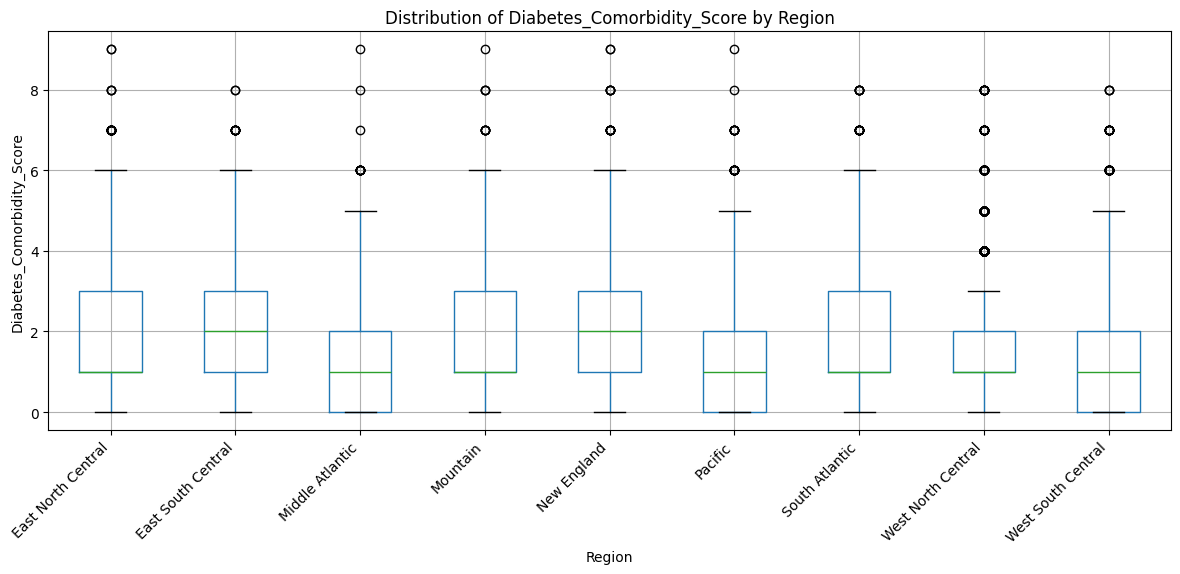

<Figure size 1200x600 with 0 Axes>

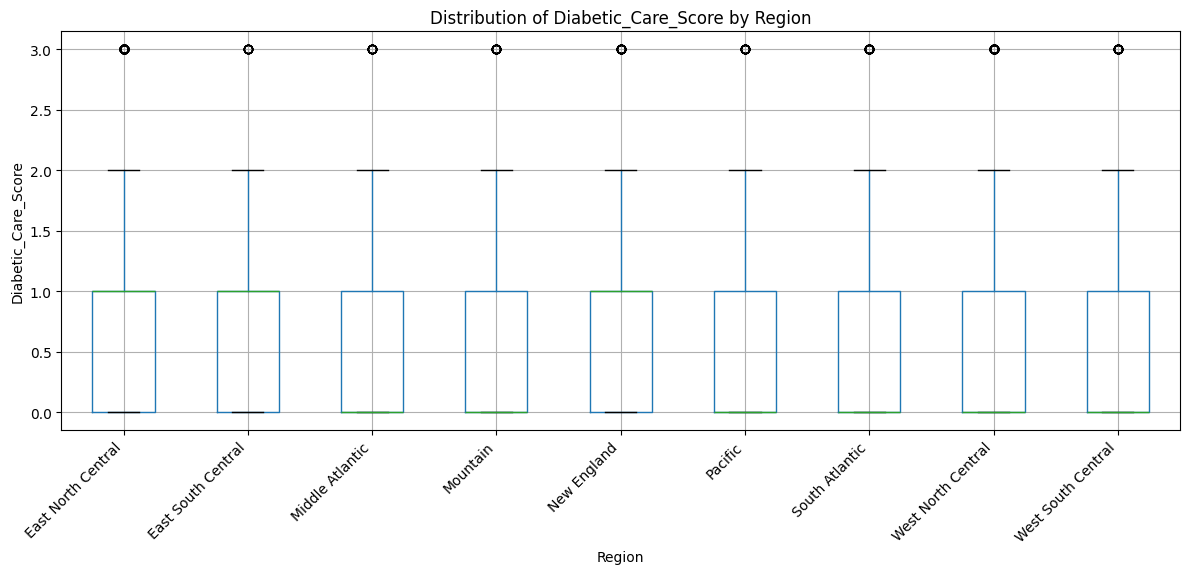

<Figure size 1200x600 with 0 Axes>

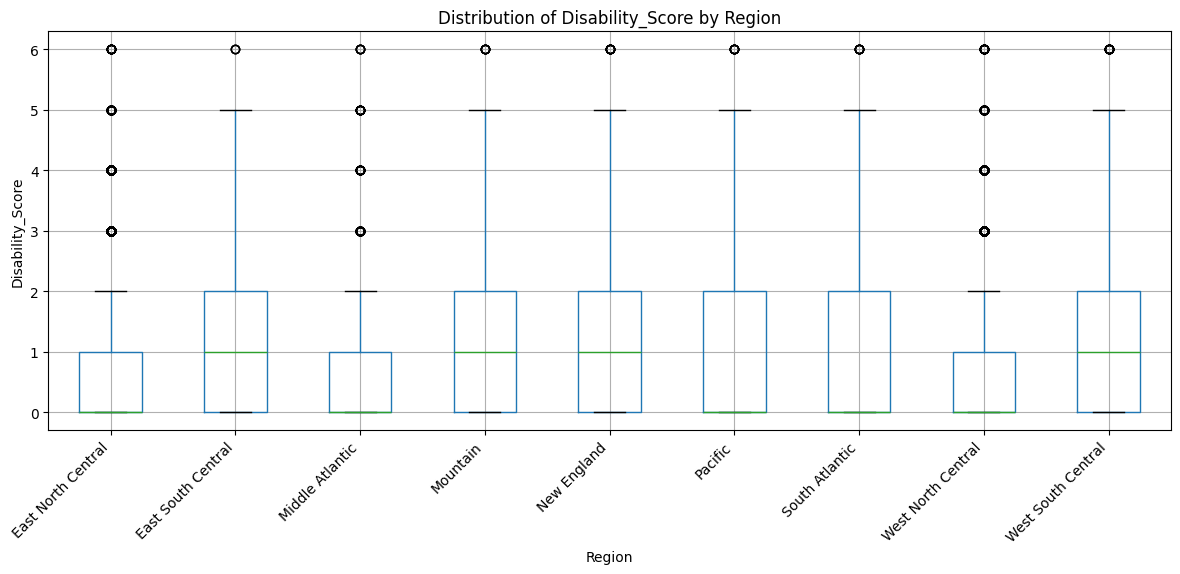

<Figure size 1200x600 with 0 Axes>

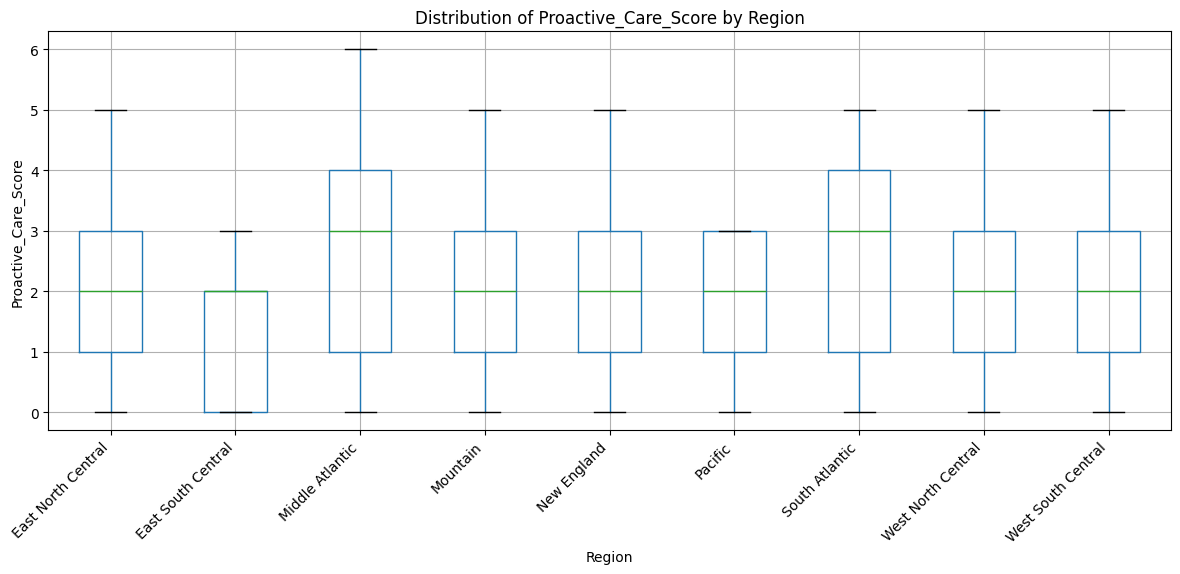

<Figure size 1200x600 with 0 Axes>

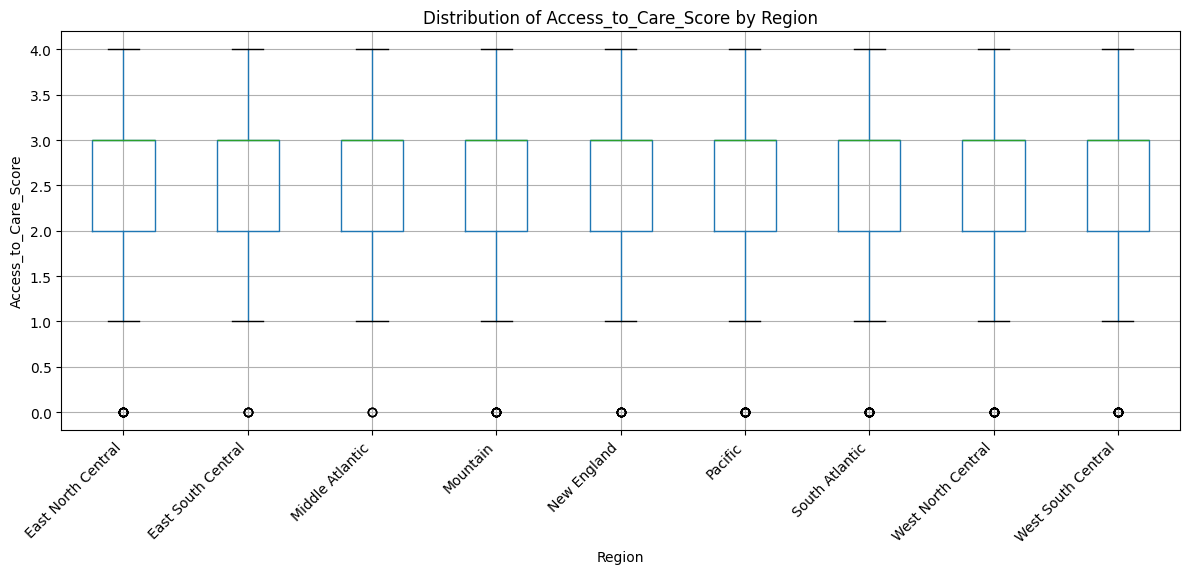

<Figure size 1200x600 with 0 Axes>

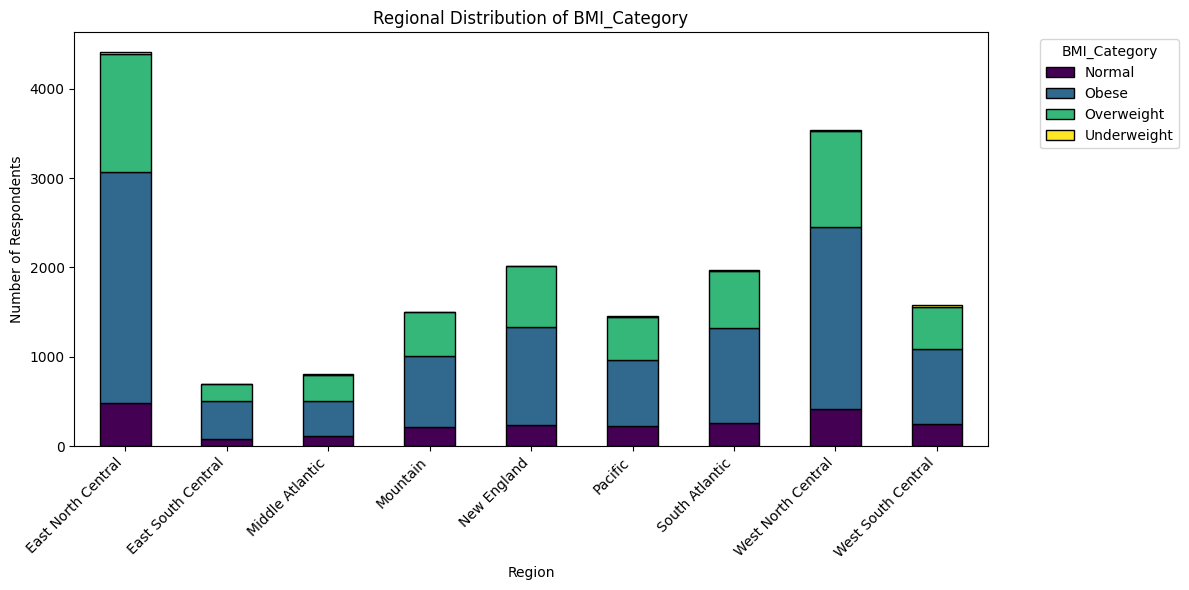

<Figure size 1200x600 with 0 Axes>

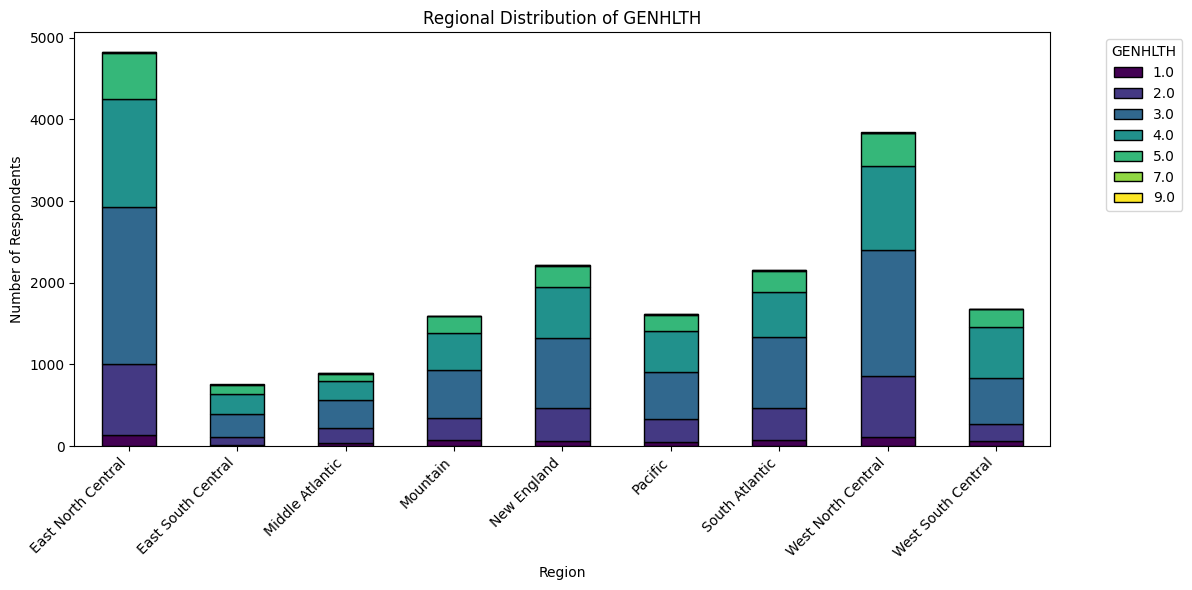

In [34]:
key_health_indicators = [
    'Diabetes_Comorbidity_Score',
    'Diabetic_Care_Score',
    'Disability_Score', # Corrected column name
    'Proactive_Care_Score',
    'Access_to_Care_Score', # Added new score
    'BMI_Category',
    'GENHLTH' # General Health
]

# Updated lists for plotting based on the corrected and new scores
categorical_indicators = ['BMI_Category', 'GENHLTH']
numerical_indicators = ['Diabetes_Comorbidity_Score', 'Diabetic_Care_Score', 'Disability_Score', 'Proactive_Care_Score', 'Access_to_Care_Score']

for indicator in key_health_indicators:
    plt.figure(figsize=(12, 6))
    if indicator in categorical_indicators:
        # Stacked bar plot for categorical indicators
        # Drop rows where either Region or the indicator is NaN and create a copy
        plot_data = df.dropna(subset=['Region', indicator]).copy()
        # Ensure categorical data is treated as string for consistent plotting
        plot_data[indicator] = plot_data[indicator].astype(str)

        # Crosstab and plot
        ct = pd.crosstab(plot_data['Region'], plot_data[indicator])
        ct.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis', edgecolor='black')
        plt.title(f'Regional Distribution of {indicator}')
        plt.xlabel('Region')
        plt.ylabel('Number of Respondents')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title=indicator, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    elif indicator in numerical_indicators:
        # Box plot for numerical indicators
        # Drop rows where either Region or the indicator is NaN and create a copy
        plot_data = df.dropna(subset=['Region', indicator]).copy()

        plot_data.boxplot(column=indicator, by='Region', figsize=(12, 6))
        plt.title(f'Distribution of {indicator} by Region')
        plt.suptitle('') # Suppress the default title from boxplot
        plt.xlabel('Region')
        plt.ylabel(indicator)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Indicator '{indicator}' is not defined as categorical or numerical for plotting.")

## Clean Up Final Columns / Remove Unneeded

In [35]:
#get section categories
sections = {
    "Record_Identification": ['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE', 'SEQNO', '_PSU'],
    "Phone_Introduction": ['CTELENM1', 'CELPHON1', 'PVTRESD1','COLGHOUS', 'STATERE1', 'LADULT1', 'NUMADULT','RESPSLC1', 'LANDSEX2','SAFETIME', 'CTELNUM1', 'CELLFON5', 'CADULT1', 'CELLSEX2', 'PVTRESD3', 'CCLGHOUS', 'CSTATE1',
    'LANDLINE', 'HHADULT'],
    'Respondent_Sex': ['SEXVAR'],
    'Health_Status': ['GENHLTH'],
    'Healthy_Days': ['PHYSHLTH', 'MENTHLTH', 'POORHLTH'],
    'Healthcare_Access': ['PRIMINS1', 'PERSDOC3','MEDCOST1', 'CHECKUP1'],
    'Exercise' : ['EXERANY2', 'EXRACT12', 'EXEROFT1', 'EXERHMM1', 'EXRACT22', 'EXEROFT2', 'EXERHMM2', 'STRENGTH'],
    'Hypertension_Awareness': ['BPHIGH6', 'BPMEDS1'],
    'Cholestrol_Awareness': ['CHOLCHK3', 'TOLDHI3', 'CHOLMED3'],
    'Chronic_Health_Conditions': ['CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1',
                                  'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'DIABAGE4'],
    'Demographics': ['MARITAL', 'EDUCA', 'RENTHOM1', 'NUMHHOL4', 'NUMPHON4', 'CPDEMO1C', 'VETERAN3', 'EMPLOY1',
                     'CHILDREN','INCOME3', 'PREGNANT', 'WEIGHT2', 'HEIGHT3'],
    'Disability': ['DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON'],
    'Falls': ['FALL12MN', 'FALLINJ5'],
    'Tobacco_Use': ['SMOKE100', 'SMOKDAY2', 'USENOW3', 'ECIGNOW2'],
    'Alcohol_Consumption': ['ALCDAY4', 'AVEDRNK3', 'DRNK3GE5', 'MAXDRNKS'],
    'Immunization': ['FLUSHOT7', 'FLSHTMY3', 'PNEUVAC4', 'SHINGLE2', 'HIVTST7', 'HIVTSTD3'],
    'Seatbelt_Use_Drinking_and_Driving': ['SEATBELT', 'DRNKDRI2'],
    'Long_Term_Covid_Effects': ['COVIDPO1', 'COVIDSM1', 'COVIDACT'],
    'Pre_Diabetes': ['PDIABTS1', 'PREDIAB2'],
    'Diabetes': ['DIABTYPE', 'INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'DIABEYE1', 'DIABEDU1','FEETSORE'],
    'Arthritis': ['ARTHEXER', 'ARTHEDU', 'LMTJOIN3', 'ARTHDIS2', 'JOINPAI2'],
    'Lung_Cancer_Screening': ['LCSFIRST','LCSLAST', 'LCSNUMCG', 'LCSCTSC1', 'LCSSCNCR', 'LCSCTWHN'],
    'Breast_and_Cervical_Cancer_Screening': ['HADMAM', 'HOWLONG', 'CERVSCRN', 'CRVCLCNC', 'CRVCLPAP', 'CRVCLHPV',
                                             'HADHYST2'],
    'Prostate_Cancer_Screening': ['PSATEST1', 'PSATIME1', 'PCPSARS2', 'PSASUGS1', 'PCSTALK2'],
    'Colorectal_Cancer_Screening': ['HADSIGM4', 'COLNSIGM', 'COLNTES1', 'SIGMTES1', 'LASTSIG4', 'COLNCNCR', 'VIRCOLO1',
                                    'VCLNTES2', 'SMALSTOL', 'STOLTEST', 'STOOLDN2', 'BLDSTFIT', 'SDNATES1'],
    'Cancer_Survivorship': ['CNCRDIFF', 'CNCRAGE', 'CNCRTYP2', 'CSRVTRT3', 'CSRVDOC1', 'CSRVSUM', 'CSRVRTRN', 'CSRVINST',
                            'CSRVINSR', 'CSRVDEIN', 'CSRVCLIN', 'CSRVPAIN', 'CSRVCTL2'],
    'Indoor_Tanning': ['INDORTAN'],
    'Excess_Sun_Exposure': ['NUMBURN3', 'SUNPRTCT', 'WKDAYOUT', 'WKENDOUT'],
    'Cognitive Decline': ['CIMEMLO1', 'CDWORRY', 'CDDISCU1', 'CDHOUS1', 'CDSOCIA1'],
    'Caregiver': ['CAREGIV1', 'CRGVREL4', 'CRGVLNG1', 'CRGVHRS1', 'CRGVPRB3', 'CRGVALZD', 'CRGVPER1', 'CRGVHOU1', 'CRGVEXPT'],
    'Tobacco_Cessation': ['LASTSMK2', 'STOPSMK2', 'MENTCIGS', 'MENTECIG', 'HEATTBCO'],
    'Firearm_Safety': ['FIREARM5', 'GUNLOAD', 'LOADULK2'],
    'Heart_Attack_And_Stroke': ['HASYMP1', 'HASYMP2', 'HASYMP3', 'HASYMP4', 'HASYMP5','HASYMP6', 'STRSYMP1', 'STRSYMP2',
                                'STRSYMP3', 'STRSYMP4', 'STRSYMP5', 'STRSYMP6', 'FIRSTAID'],
    'Aspirin_for_CVD_Prevention': ['ASPIRIN'],
    'Sexual_Orientation': ['SOMALE', 'SOFEMALE'],
    'Marijuana_Use': ['MARIJAN1', 'MARJSMOK', 'MARJEAT', 'MARJVAPE', 'MARJDAB', 'MARJOTHR'],
    'Adverse_Childhood_Experiences': ['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN','ACEDIVRC', 'ACEPUNCH', 'ACEHURT1',
                                      'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX', 'ACEADSAF', 'ACEADNED'],
    'Place_of_Flu_Vaccination': ['IMFVPLA4'],
    'HPV_Vaccination': ['HPVADVC4', 'HPVADSHT'],
    'Tetanus_Diptheria': ['TETANUS1'],
    'COVID_Vaccination': ['COVIDVA1', 'COVACGE1', 'COVIDNU2'],
    'Social_Determinants': ['LSATISFY', 'EMTSUPRT', 'SDLONELY', 'SDHEMPLY', 'FOODSTMP', 'SDHFOOD1', 'SDHBILLS', 'SDHUTILS',
                            'SDHTRNSP', 'SDHSTRE1'],
    'Reactions_to_Race': ['RRCLASS3', 'RRCOGNT2', 'RRTREAT', 'RRATWRK2', 'RRHCARE4', 'RRPHYSM2'],
    'Random_Child_Selection': ['RCSBORG1', 'RCSRLTN2'],
    'Childhood_Asthma_Prevalance': ['CASTHDX2', 'CASTHNO2'],
    'Questionnaire_Version': ['QSTVER'],
    'Questionaire_Language': ['QSTLANG'],
    'Urban_Rural': ['_METSTAT', '_URBSTAT'],
    'Weighting_Variables': ['MSCODE', '_STSTR', '_STRWT', '_RAWRAKE', '_WT2RAKE', '_IMPRACE', '_DUALUSE', '_DUALCOR',
                            '_LLCPWT2', '_LLCPWT'],
    'Child_Demographic_Variables': ['_CHISPNC', '_CRACE1'],
    'Child_Weighting_Variables': ['CAGEG', '_CLLCPWT'],
    'Calculated_Variables': ['_PHYS14D', '_MENT14D', '_HLTHPL1', '_HCVU653', '_TOTINDA', 'METVL12_', 'METVL22_','MAXVO21_',
                              'FC601_', 'ACTIN13_', 'ACTIN23_', 'PADUR1_', 'PADUR2_', 'PAFREQ1_', 'PAFREQ2_', '_MINAC12',
                             '_MINAC22', 'STRFREQ_', 'PAMISS3_', 'PAMIN13_', 'PAMIN23_', 'PA3MIN_', 'PAVIG13_','PAVIG23_',
                             'PA3VIGM_', '_PACAT3', '_PAINDX3', '_PA150R4', '_PA300R4', '_PA30023', '_PASTRNG', '_PAREC3',
                             '_PASTAE3', '_RFHYPE6', '_CHOLCH3', '_RFCHOL3', '_MICHD', '_LTASTH1', '_CASTHM1', '_ASTHMS1',
                             '_DRDXAR2', '_SEX', '_AGEG5YR', '_AGE65YR', '_AGE80', '_AGE_G', 'HTIN4', 'HTM4', 'WTKG3', '_BMI5',
                             '_BMI5CAT', '_RFBMI5', '_CHLDCNT', '_EDUCAG', '_INCOMG1', '_SMOKER3', '_RFSMOK3', '_CURECI2',
                             'DRNKANY6', 'DROCDY4_', '_RFBING6', '_DRNKWK2', '_RFDRHV8', '_FLSHOT7', '_PNEUMO3', '_AIDTST4',
                             '_RFSEAT2', '_RFSEAT3', '_DRNKDRV', '_RFHLTH'],
  'Calculated_Race_Variables' : ['_MRACE1', '_HISPANC', '_RACE', '_RACEG21', '_RACEGR3', '_RACEPRV'],
    'Uncategorized': ['LNDSXBRT', 'CELSXBRT', 'BIRTHSEX', 'TRNSGNDR', 'USEMRJN4', 'RCSGEND1', 'RCSXBRTH']
}


In [36]:
#find what we have left for what given sections
for section_name, column_list in sections.items():
    existing_cols = [col for col in column_list if col in df.columns]
    if existing_cols:
        print(f"\n=== {section_name} ===")
        for col in existing_cols:
            print(col)


=== Record_Identification ===
_STATE

=== Respondent_Sex ===
SEXVAR

=== Health_Status ===
GENHLTH

=== Healthy_Days ===
PHYSHLTH
POORHLTH

=== Exercise ===
EXERANY2

=== Chronic_Health_Conditions ===
ASTHNOW
CHCSCNC1
CHCOCNC1
DIABAGE4

=== Demographics ===
MARITAL
EDUCA
RENTHOM1
EMPLOY1
CHILDREN
INCOME3
WEIGHT2
HEIGHT3

=== Falls ===
FALL12MN
FALLINJ5

=== Alcohol_Consumption ===
ALCDAY4
DRNK3GE5
MAXDRNKS

=== Immunization ===
FLSHTMY3
HIVTST7
HIVTSTD3

=== Diabetes ===
CHKHEMO3
DIABEYE1

=== Tobacco_Cessation ===
LASTSMK2
STOPSMK2
MENTCIGS
MENTECIG
HEATTBCO

=== Aspirin_for_CVD_Prevention ===
ASPIRIN

=== Marijuana_Use ===
MARIJAN1

=== Urban_Rural ===
_URBSTAT

=== Weighting_Variables ===
_IMPRACE

=== Calculated_Variables ===
_AGE80


In [37]:
#last columns to drop
cols_to_drop = ['_STATE', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1', 'DIABAGE4',
                'WEIGHT2', 'HEIGHT3', 'ALCDAY4', 'DRNK3GE5', 'MAXDRNKS',
                'FLSHTMY3', 'HIVTST7', 'HIVTSTD3', 'DIABEYE1', 'CHKHEMO3',
                'LASTSMK2', 'STOPSMK2', 'MENTCIGS', 'MENTECIG', 'HEATTBCO',
                'MARIJAN1', 'MARITAL', 'EDUCA', 'RENTHOM1', 'EMPLOY1',
                'CHILDREN', 'INCOME3', 'ASPIRIN', 'Height_in_Inches',
                'Weight_in_Lbs']

#drop cols
df = df.drop(columns=cols_to_drop)
noise_shape = df.shape
print(f"Last updated dataframe shape:", cog_shape)
print(f"New shape after new indicator:",noise_shape )

Last updated dataframe shape: (20069, 48)
New shape after new indicator: (20069, 23)


In [38]:
for section_name, column_list in sections.items():
    existing_cols = [col for col in column_list if col in df.columns]
    if existing_cols:
        print(f"\n=== {section_name} ===")
        for col in existing_cols:
            print(col)


=== Respondent_Sex ===
SEXVAR

=== Health_Status ===
GENHLTH

=== Healthy_Days ===
PHYSHLTH
POORHLTH

=== Exercise ===
EXERANY2

=== Falls ===
FALL12MN
FALLINJ5

=== Urban_Rural ===
_URBSTAT

=== Weighting_Variables ===
_IMPRACE

=== Calculated_Variables ===
_AGE80


In [39]:
#clean up / convert to numeric

covert_cols = ['PHYSHLTH', 'POORHLTH', 'FALL12MN', 'FALLINJ5']
df[covert_cols] = df[covert_cols].apply(pd.to_numeric, errors='coerce')

# remap special codes:
#    88 → 0
#    77, 99 → NaN (will also cover any existing NaNs)
df[covert_cols] = df[covert_cols].replace({
    88: 0,
    77: pd.NA,
    99: pd.NA
})

binary_convert_cols = ['EXERANY2', 'GENHLTH']
df[binary_convert_cols] = df[binary_convert_cols].apply(pd.to_numeric, errors='coerce')
df[binary_convert_cols] = df[binary_convert_cols].replace({
    7: pd.NA,
    9: pd.NA
})

In [40]:
df.dtypes

SEXVAR                        float64
GENHLTH                        object
PHYSHLTH                       object
POORHLTH                       object
EXERANY2                      float64
FALL12MN                       object
FALLINJ5                       object
_URBSTAT                      float64
_IMPRACE                      float64
_AGE80                        float64
Diabetes_Comorbidity_Score    float64
Diabetic_Care_Score            object
Disability_Score              float64
Proactive_Care_Score           object
Access_to_Care_Score           object
Alcohol_Abuse_Indicator        object
Tobacco_Score                 float64
social_score                    Int64
Marijuana_Score               float64
Cognitive_Score               float64
BMI_Value                      object
BMI_Category                   object
Region                         object
dtype: object

## Create a download file for the new EDA and for it to have machine learning applied to it

#### Variables used for the scores will be dropped

In [42]:
df_cleaned = df.copy()
# df_cleaned.to_csv('/content/drive/MyDrive/ADS 504 | Final Project/diabetes_features_engineered.csv')  #  uncomment this
df_cleaned.to_csv('diabetes_features_engineered.csv')  # Save cleaned DataFrame to CSV

print("final shape:", df.shape)
print("\nFirst 5 rows of the cleaned DataFrame:")
display(df_cleaned.head())

final shape: (20069, 23)

First 5 rows of the cleaned DataFrame:


,SEXVAR,GENHLTH,PHYSHLTH,POORHLTH,EXERANY2,FALL12MN,FALLINJ5,_URBSTAT,_IMPRACE,_AGE80,...,Proactive_Care_Score,Access_to_Care_Score,Alcohol_Abuse_Indicator,Tobacco_Score,social_score,Marijuana_Score,Cognitive_Score,BMI_Value,BMI_Category,Region
0,2.0,3.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,71.0,...,2,3,<NA>,8.0,1,0.0,0.0,39.475098,Obese,Pacific
1,1.0,2.0,1.0,1.0,1.0,0.0,NaN,1.0,1.0,68.0,...,3,3,0,4.0,0,0.0,0.0,23.170166,Normal,Pacific
2,2.0,3.0,0.0,0.0,2.0,0.0,NaN,1.0,1.0,57.0,...,3,3,<NA>,6.0,0,0.0,0.0,25.603538,Overweight,Pacific
3,2.0,2.0,0.0,NaN,2.0,0.0,NaN,1.0,1.0,70.0,...,2,2,<NA>,4.0,0,0.0,0.0,42.961111,Obese,Pacific
4,2.0,5.0,30.0,25.0,2.0,0.0,NaN,1.0,1.0,74.0,...,1,2,<NA>,4.0,2,0.0,0.0,<NA>,<NA>,Pacific
